In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../notebooks/spotify-2023.csv")
OUT  = Path("../reports/figures"); OUT.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA, encoding="ISO-8859-1")
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


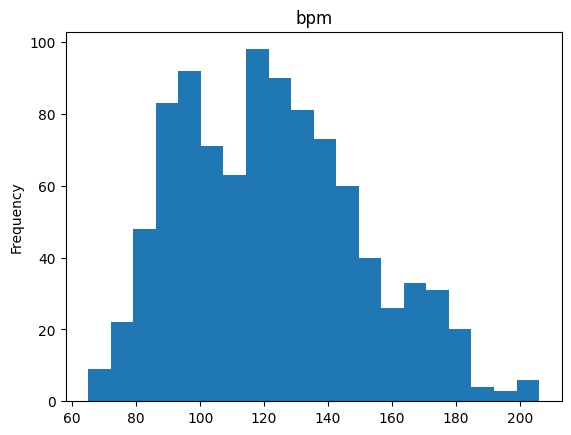

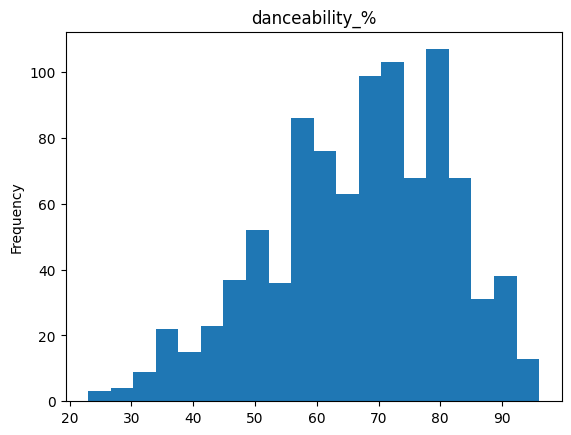

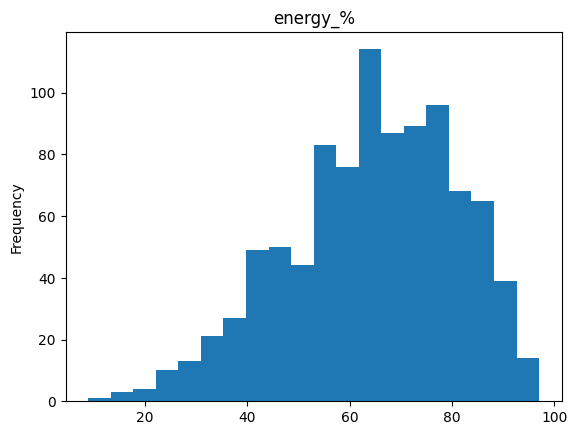

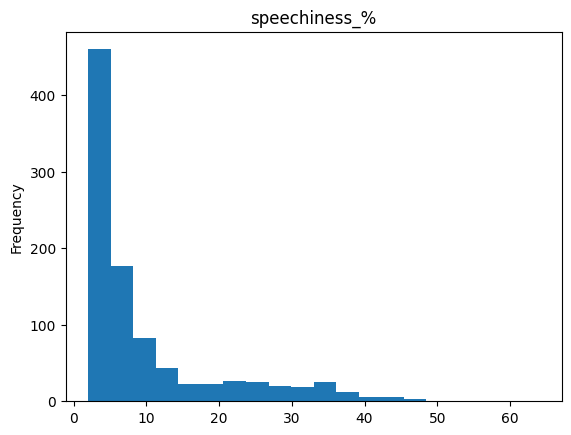

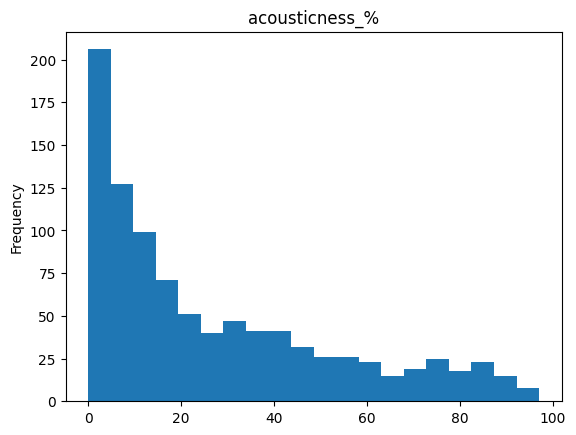

In [2]:
numeric = ["bpm","danceability_%","energy_%","speechiness_%","acousticness_%"]

for col in numeric:
    ax = df[col].plot(kind="hist", bins=20, title=col)
    ax.figure.savefig(OUT/f"{col}_hist.png", bbox_inches="tight")
    plt.show()


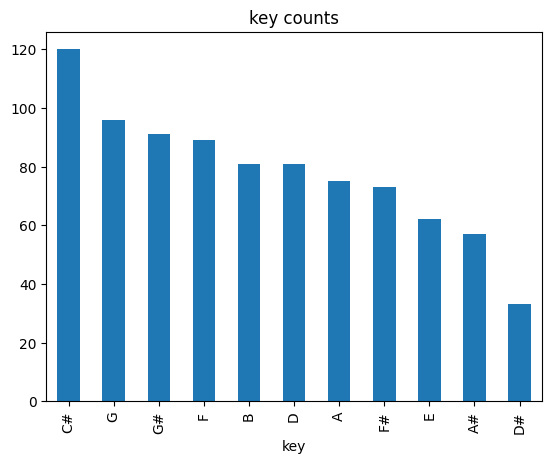

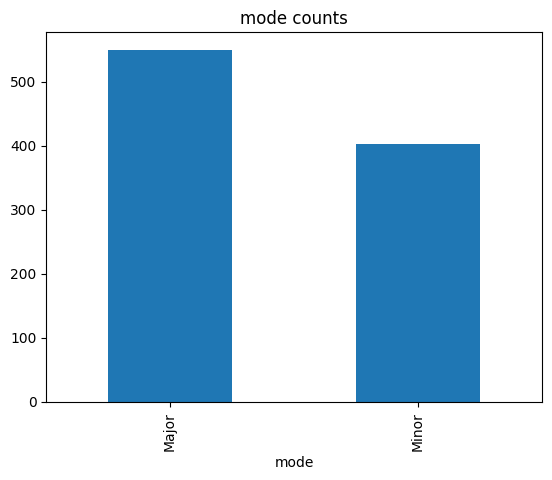

In [3]:
for col in ["key","mode"]:
    ax = df[col].value_counts().plot(kind="bar", title=f"{col} counts")
    ax.figure.savefig(OUT/f"{col}_counts.png", bbox_inches="tight")
    plt.show()


In [4]:
def densest_bin_range(x, bins=20):
    counts, edges = np.histogram(x.dropna().values, bins=bins)
    i = counts.argmax()
    return float(edges[i]), float(edges[i+1])

typical = {col: densest_bin_range(df[col]) for col in numeric}
typical.update({col: df[col].mode().iat[0] for col in ["key","mode"]})
typical


{'bpm': (114.35, 121.4),
 'danceability_%': (77.75, 81.4),
 'energy_%': (61.800000000000004, 66.2),
 'speechiness_%': (2.0, 5.1),
 'acousticness_%': (0.0, 4.85),
 'key': 'C#',
 'mode': 'Major'}

In [5]:
crit = (
    df['bpm'].between(*typical['bpm']) &
    df['danceability_%'].between(*typical['danceability_%']) &
    df['energy_%'].between(*typical['energy_%']) &
    df['speechiness_%'].between(*typical['speechiness_%']) &
    df['acousticness_%'].between(*typical['acousticness_%']) &
    (df['key'] == typical['key']) &
    (df['mode'] == typical['mode'])
)

cols = ['track_name','artist(s)_name','streams','in_spotify_charts','bpm','key','mode','danceability_%','energy_%','speechiness_%','acousticness_%']
hits = df.loc[crit, cols].sort_values('streams', ascending=False)
hits.head(20)


,track_name,artist(s)_name,streams,in_spotify_charts,bpm,key,mode,danceability_%,energy_%,speechiness_%,acousticness_%


In [6]:
from pathlib import Path
import json

ROOT = Path.cwd().parent if Path.cwd().name=="notebooks" else Path.cwd()
OUT  = ROOT / "reports"; OUT.mkdir(exist_ok=True, parents=True)

# Save criteria
(Path(OUT) / "typical.json").write_text(json.dumps(typical, indent=2))

# Save matching tracks
hits.to_csv(OUT / "matching_tracks.csv", index=False)

print("Saved:", OUT / "typical.json")
print("Saved:", OUT / "matching_tracks.csv")


Saved: c:\Users\Stephen\spotify-hit-lab\reports\typical.json
Saved: c:\Users\Stephen\spotify-hit-lab\reports\matching_tracks.csv


In [7]:
df['streams'] = (
    df['streams'].astype(str).str.replace(',', '', regex=False)
    .pipe(pd.to_numeric, errors='coerce')
)

# in_spotify_charts can have non-numeric entries; coerce and fill NaN with 0
df['in_spotify_charts'] = pd.to_numeric(df['in_spotify_charts'], errors='coerce').fillna(0).astype(int)

# (Optional) show how many rows became NaN after coercion
df[['streams','in_spotify_charts']].isna().sum()


streams              1
in_spotify_charts    0
dtype: int64

In [8]:
df = df.dropna(subset=['streams']).copy()


In [9]:
global_streams_median = df['streams'].median()

summary = hits.assign(
    popular = (pd.to_numeric(hits['streams'], errors='coerce') > global_streams_median) |
              (pd.to_numeric(hits['in_spotify_charts'], errors='coerce').fillna(0) > 0)
)[['track_name','artist(s)_name','streams','in_spotify_charts','popular']]

summary.head(10)


,track_name,artist(s)_name,streams,in_spotify_charts,popular


In [10]:
known = df[df['track_name'].str.contains("Cruel Summer", case=False, na=False)].copy()
known.loc[:, ['track_name','artist(s)_name','bpm','key','mode','danceability_%','energy_%','speechiness_%','acousticness_%']]


,track_name,artist(s)_name,bpm,key,mode,danceability_%,energy_%,speechiness_%,acousticness_%
3,Cruel Summer,Taylor Swift,170,A,Major,55,72,15,11
